In [4]:
%pip install netCDF4
%pip install zstandard

  Using cached netcdf4-1.7.1.post2.tar.gz (827 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for cftime from https://files.pythonhosted.org/packages/7f/ec/8333fb2229a3efd17f59a7fcc295c09cce8db3dd956de58c20f55926b533/cftime-1.6.4-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 6.8 MB/s eta 0:00:00
  Created wheel for netCDF4: filename=netCDF4-1.7.1.post2-cp311-cp311-macosx_11_0_arm64.whl size=567047 sha256=565cdb92a96725a317cbd255b5a8db73280b040320d83791e090b1755aa96e60
  Stored in directory: /Users/jefferywei/Library/Caches/pip/wheels/4e/46/eb/16e9b4ed6f3f5b90e4a6f251e72d4de0d4b642509652f7b178
Successfully built netCDF4
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [38]:
import os
from netCDF4 import Dataset
import zstandard as zstd
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [47]:
def read_file_with_var(read_file_name, var_name):
    data = Dataset("data/" + read_file_name)

    var = data.variables[var_name]
    var_data = var[:]

    output = var_data.tobytes()

    write_path = "data/output/binary/uncompressed/" + read_file_name + "_" + var_name + ".bin"
    os.makedirs(os.path.dirname(write_path), exist_ok=True)

    with open(write_path, "wb") as file:
        file.write(output)
        print(f"File written to {write_path}")

    data.close()

In [48]:
def zstd_compress(file_name, compressed_file_name):
    cctx = zstd.ZstdCompressor()

    with open(file_name, "rb") as file:
        file_data = file.read()
    
    compressed = cctx.compress(file_data)

    os.makedirs(os.path.dirname(compressed_file_name), exist_ok=True)

    with open(compressed_file_name, "wb") as compressed_file:
        compressed_file.write(compressed)
        print(f"File compressed and written to {compressed_file_name}")

In [49]:
def get_file_size(file_name):
    file_size = os.path.getsize(file_name)
    print(f"Size of {file_name}: {file_size} bytes")
    return file_size

In [50]:
def compression_ratio(original_file, compressed_file):
    original_size = get_file_size(original_file)
    compressed_size = get_file_size(compressed_file)

    ratio = original_size / compressed_size

    data = [original_size, compressed_size, ratio]
    print(f"Compression ratio: {ratio:.2f}")
    return data

In [51]:
def compress_all_vars(read_file_name):
    data = Dataset("data/" + read_file_name)
    compression_ratios = {}
    size_comparison = {}

    for var_name in data.variables.keys():
        uncompressed_file_path = "data/output/binary/uncompressed/" + read_file_name + "_" + var_name + ".bin"
        compressed_file_path = "data/output/binary/compressed/" + read_file_name + "_" + var_name + "_compressed.bin"

        read_file_with_var(read_file_name, var_name)
        zstd_compress(uncompressed_file_path, compressed_file_path)
        compression_ratios[var_name] = compression_ratio(uncompressed_file_path, compressed_file_path)[2]
        size_comparison[var_name] = {
            "original": compression_ratio(uncompressed_file_path, compressed_file_path)[0],
            "compressed": compression_ratio(uncompressed_file_path, compressed_file_path)[1]
        }

    data.close()

    ratio_write_path = "data/output/ratios/" + read_file_name + "_ratios.json"
    comparison_write_path = "data/output/comparison/" + read_file_name + "_comparison.json"
    os.makedirs(os.path.dirname(ratio_write_path), exist_ok=True)
    os.makedirs(os.path.dirname(comparison_write_path), exist_ok=True)
    
    with open(ratio_write_path, "w") as outfile:
        json.dump(compression_ratios, outfile, indent=4)
        print(f"Compression ratios written to {ratio_write_path}")
    
    with open(comparison_write_path, "w") as outfile:
        json.dump(size_comparison, outfile, indent=4)
        print(f"File size comparisons written to {comparison_write_path}")

In [52]:
compress_all_vars("GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4")

File written to data/output/binary/uncompressed/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_lon.bin
File compressed and written to data/output/binary/compressed/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_lon_compressed.bin
Size of data/output/binary/uncompressed/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_lon.bin: 9216 bytes
Size of data/output/binary/compressed/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_lon_compressed.bin: 1462 bytes
Compression ratio: 6.30
Size of data/output/binary/uncompressed/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_lon.bin: 9216 bytes
Size of data/output/binary/compressed/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_lon_compressed.bin: 1462 bytes
Compression ratio: 6.30
Size of data/output/binary/uncompressed/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_lon.bin: 9216 bytes
Size of data/output/binary/compressed/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_lon_compressed.bin: 1462 bytes
Compression ratio: 6.30
File 

In [62]:
def ratio_plot(directory_path):
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        
        if os.path.isfile(file_path):
            with open(file_path, 'r') as file:
                data = json.load(file)

                keys = list(data.keys())
                values = list(data.values())

                plt.figure(figsize=(10, 6))
                plt.bar(keys, values, color='skyblue')
                plt.xlabel('Variable')
                plt.ylabel('Ratio')
                plt.title('Variable Compression Ratios')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.savefig("data/output/ratios/" + filename + ".png")
                plt.show()

In [63]:
def comparison_plot(directory_path):
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        
        if os.path.isfile(file_path):
            with open(file_path, 'r') as file:
                data = json.load(file)

                keys = list(data.keys())
                original_values = [data[key]['original'] for key in keys]
                compressed_values = [data[key]['compressed'] for key in keys]

                x = np.arange(len(keys))
                width = 0.35

                fig, ax = plt.subplots(figsize=(12, 6))
                bars1 = ax.bar(x - width/2, original_values, width, label='Original', color='skyblue')
                bars2 = ax.bar(x + width/2, compressed_values, width, label='Compressed', color='lightgreen')

                ax.set_xlabel('Keys')
                ax.set_ylabel('Size')
                ax.set_title('Original vs Compressed Sizes')
                ax.set_xticks(x)
                ax.set_xticklabels(keys, rotation=45)
                ax.legend()

                plt.tight_layout()
                plt.savefig("data/output/comparison/" + filename + ".png")
                plt.show()

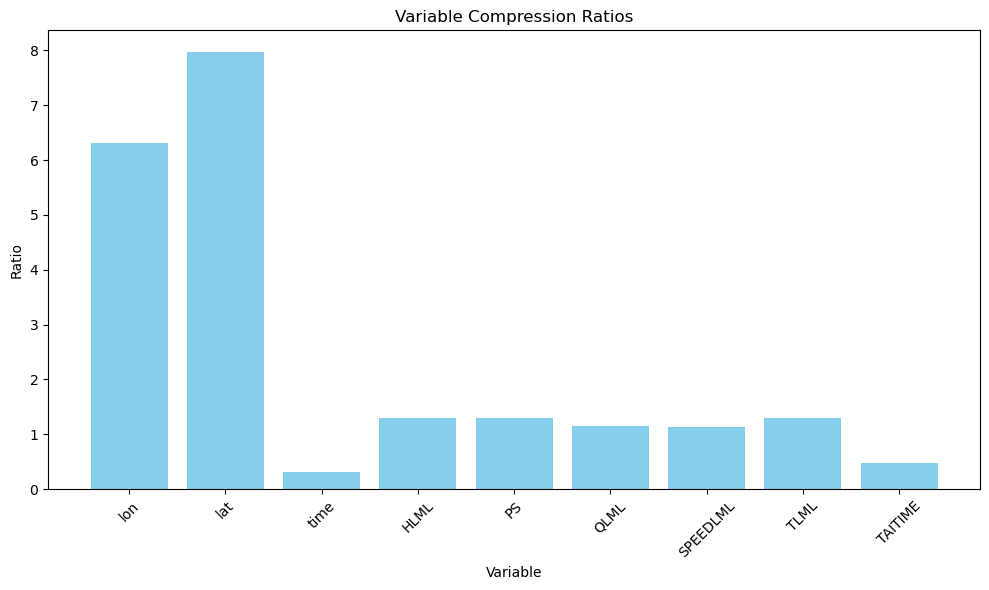

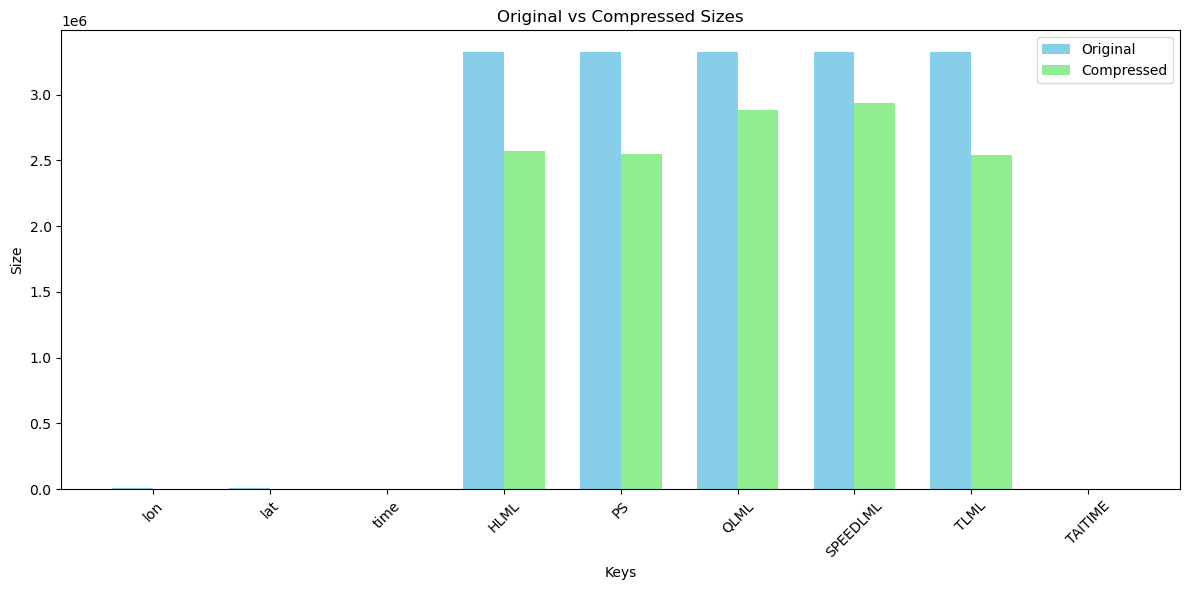

In [64]:
ratio_plot("data/output/ratios")
comparison_plot("data/output/comparison")